In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import scIB
import pickle

In [2]:
default_fig_size = (8,8)
plt.rcParams['figure.figsize'] = default_fig_size
data_dir = '../data/'

In [3]:
integrated = pickle.load(open(data_dir+'processed/integrated_dict.h5ad', "rb"))

## Silhouette score

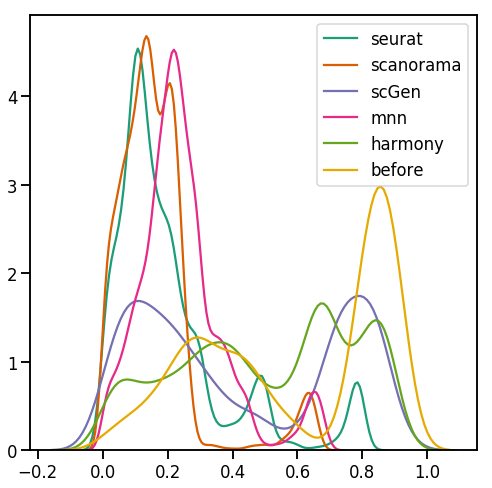

In [4]:
scIB.metrics.plot_silhouette_score(integrated, verbose=False)

## Simple Cluster overlap

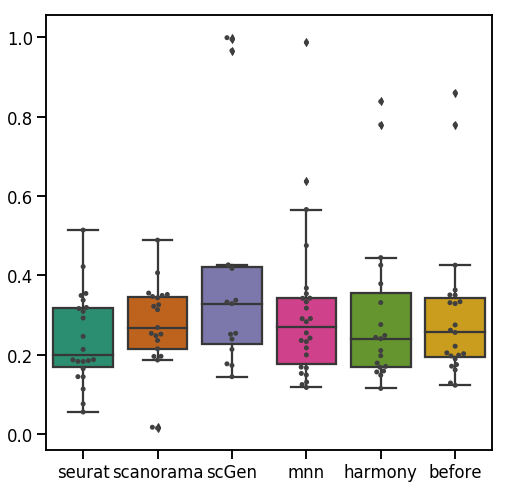

In [5]:
scIB.metrics.plot_cluster_overlap(integrated, group1='louvain', group2='louvain_post', df=False)

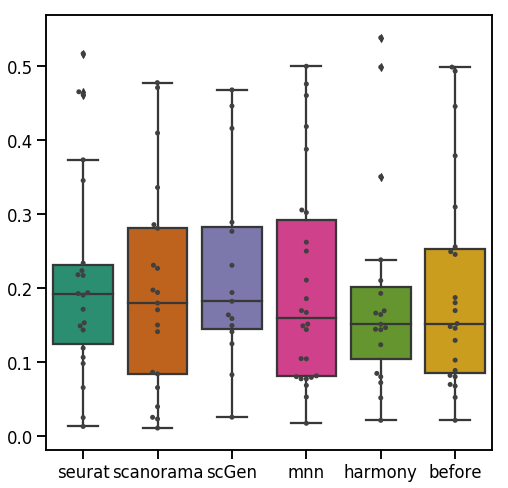

In [6]:
scIB.metrics.plot_cluster_overlap(integrated, group1='cell_ontology_class', group2='louvain_post', df=False)

## NMI Normalized mutual information

Scikit-learn implementation

In [15]:
for tool_name, adata in integrated.items():
    print(tool_name)
    print(scIB.metrics.nmi(adata, group1='louvain', group2='louvain_post', average_method='min'))
    print(scIB.metrics.nmi(adata, group1='cell_ontology_class', group2='louvain_post', average_method='min'))

seurat
0.8358180016180944
0.7869760559746058
scanorama
0.8701934023641373
0.7754336189857238
scGen
0.9277294345015912
0.7838692399379167
mnn
0.868110000307116
0.7921626417174817
harmony
0.8098444675443105
0.7295321789901913
before
0.8556539745628361
0.7697012310365622


In [11]:
nmi_dir = '../../../mutual3/'
for tool_name, adata in integrated.items():
    print(tool_name)
    print(scIB.metrics.nmi_Lanc(adata, group1='louvain', group2='louvain_post', nmi_dir=nmi_dir))
    print(scIB.metrics.nmi_Lanc(adata, group1='cell_ontology_class', group2='louvain_post', nmi_dir=nmi_dir))

seurat
0.574931
0.390004
scanorama
0.632002
0.369414
scGen
0.660695
0.379194
mnn
0.474721
0.327479
harmony
0.487643
0.305196
before
0.456123
0.298403


Overlap-NMI

In [12]:
onmi_dir = '../../../Overlapping-NMI/'
for tool_name, adata in integrated.items():
    print(tool_name)
    print(scIB.metrics.onmi(adata, group1='louvain', group2='louvain_post', onmi_dir=onmi_dir))
    print(scIB.metrics.onmi(adata, group1='cell_ontology_class', group2='louvain_post', onmi_dir=onmi_dir))

seurat
0.612355
0.46409
scanorama
0.68979
0.494046
scGen
0.685442
0.448052
mnn
0.494484
0.357784
harmony
0.521413
0.385919
before
0.506922
0.35043


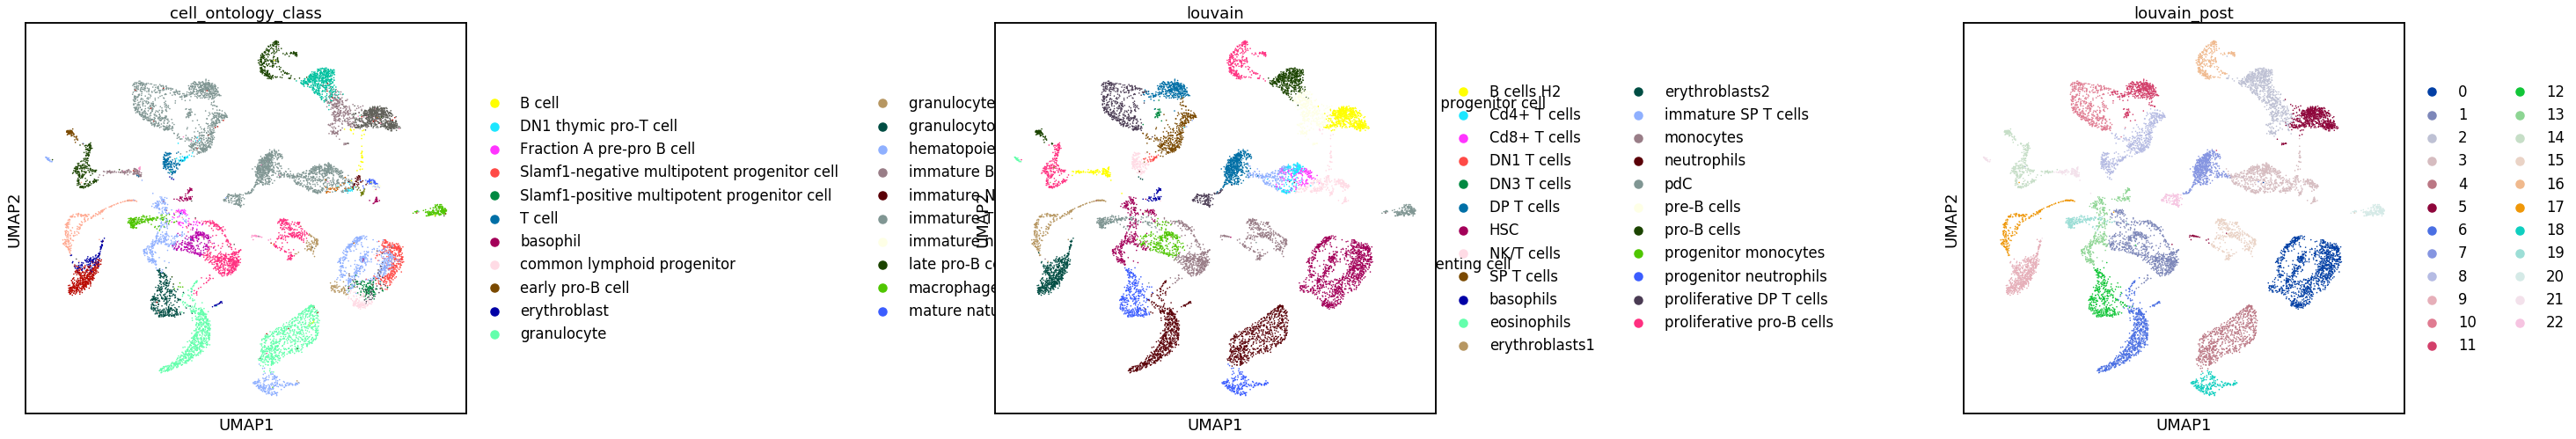

In [9]:
sc.pl.umap(integrated['before'], color=['cell_ontology_class', 'louvain', 'louvain_post'], wspace=1)

## ARI Adjusted rand index

In [10]:
for tool_name, adata in integrated.items():
    print(tool_name)
    print(scIB.metrics.ari(adata, group1='louvain', group2='louvain_post'))
    print(scIB.metrics.ari(adata, group1='cell_ontology_class', group2='louvain_post'))

seurat
0.6962659453340518
0.5341634950185414
scanorama
0.7903407656306083
0.5521819467426529
scGen
0.8379049174843873
0.5592242344774752
mnn
0.6290794042690064
0.4220263239559428
harmony
0.6555225790404756
0.519204263813725
before
0.6541512190824804
0.41955710725812534
